In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu' )
device

device(type='cpu')

# Dataset & Dataloader 

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
bs = 128

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True, num_workers=2)

In [4]:
images, labels = next(iter(trainloader))
images.shape

torch.Size([128, 1, 28, 28])

In [5]:
label2cat = train_set.classes
label2cat 

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Architecture and Config

In [9]:
from jcopdl.layers import linear_block

In [11]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=0.2),
            linear_block(n1,n2, dropout=0.2),
            linear_block(n2, output_size, activation='lsoftmax'),
        )
        
    def forward(self, x):
        return self.fc(x)

In [13]:
config = set_config({
    "input_size": 784,
    "n1": 256,
    "n2": 64,
    "output_size": len(train_set.classes),
    "dropout": 0.2
})

# Training Prep -> MCOC 

In [14]:
config.input_size

784

In [15]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model')

# Training 

In [16]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch     1
Train_cost  = 0.7406 | Test_cost  = 0.4610 | Train_score = 0.7366 | Test_score = 0.8330 |


Train:   0%|          | 0/313 [00:07<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch     2
Train_cost  = 0.4786 | Test_cost  = 0.4194 | Train_score = 0.8317 | Test_score = 0.8449 |


Train:   0%|          | 0/313 [00:07<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch     3
Train_cost  = 0.4253 | Test_cost  = 0.3879 | Train_score = 0.8488 | Test_score = 0.8558 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch     4
Train_cost  = 0.3938 | Test_cost  = 0.3742 | Train_score = 0.8579 | Test_score = 0.8631 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch     5
Train_cost  = 0.3692 | Test_cost  = 0.3484 | Train_score = 0.8666 | Test_score = 0.8701 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch     6
Train_cost  = 0.3560 | Test_cost  = 0.3392 | Train_score = 0.8716 | Test_score = 0.8740 |


Train:   0%|          | 0/313 [00:07<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch     7
Train_cost  = 0.3411 | Test_cost  = 0.3410 | Train_score = 0.8775 | Test_score = 0.8767 |


Train:   0%|          | 0/313 [00:07<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch     8
Train_cost  = 0.3309 | Test_cost  = 0.3266 | Train_score = 0.8799 | Test_score = 0.8803 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch     9
Train_cost  = 0.3187 | Test_cost  = 0.3382 | Train_score = 0.8841 | Test_score = 0.8750 |
==> EarlyStop patience =  1 | Best test_score: 0.8803


Train:   0%|          | 0/313 [00:07<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    10
Train_cost  = 0.3098 | Test_cost  = 0.3234 | Train_score = 0.8884 | Test_score = 0.8815 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    11
Train_cost  = 0.3011 | Test_cost  = 0.3299 | Train_score = 0.8903 | Test_score = 0.8784 |
==> EarlyStop patience =  1 | Best test_score: 0.8815


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    12
Train_cost  = 0.2942 | Test_cost  = 0.3081 | Train_score = 0.8927 | Test_score = 0.8874 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    13
Train_cost  = 0.2889 | Test_cost  = 0.3135 | Train_score = 0.8947 | Test_score = 0.8840 |
==> EarlyStop patience =  1 | Best test_score: 0.8874


Train:   0%|          | 0/313 [00:07<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch    14
Train_cost  = 0.2827 | Test_cost  = 0.3223 | Train_score = 0.8971 | Test_score = 0.8827 |
==> EarlyStop patience =  2 | Best test_score: 0.8874


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    15
Train_cost  = 0.2715 | Test_cost  = 0.3140 | Train_score = 0.8996 | Test_score = 0.8871 |
==> EarlyStop patience =  3 | Best test_score: 0.8874


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    16
Train_cost  = 0.2686 | Test_cost  = 0.3104 | Train_score = 0.9009 | Test_score = 0.8902 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    17
Train_cost  = 0.2626 | Test_cost  = 0.3122 | Train_score = 0.9030 | Test_score = 0.8855 |
==> EarlyStop patience =  1 | Best test_score: 0.8902


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    18
Train_cost  = 0.2619 | Test_cost  = 0.3119 | Train_score = 0.9039 | Test_score = 0.8880 |
==> EarlyStop patience =  2 | Best test_score: 0.8902


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    19
Train_cost  = 0.2511 | Test_cost  = 0.3104 | Train_score = 0.9065 | Test_score = 0.8888 |
==> EarlyStop patience =  3 | Best test_score: 0.8902


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch    20
Train_cost  = 0.2487 | Test_cost  = 0.3031 | Train_score = 0.9072 | Test_score = 0.8898 |


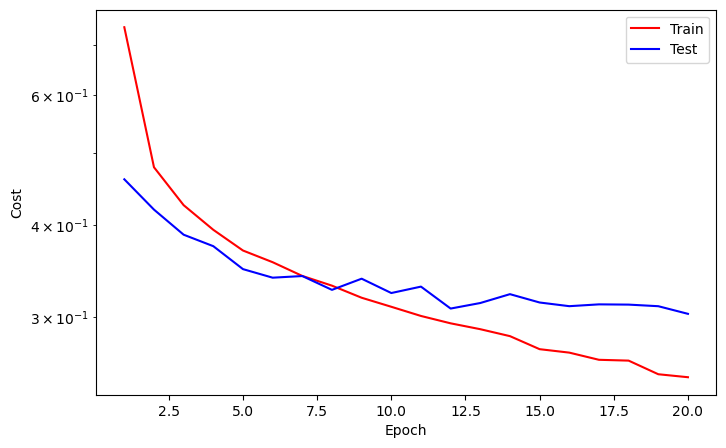

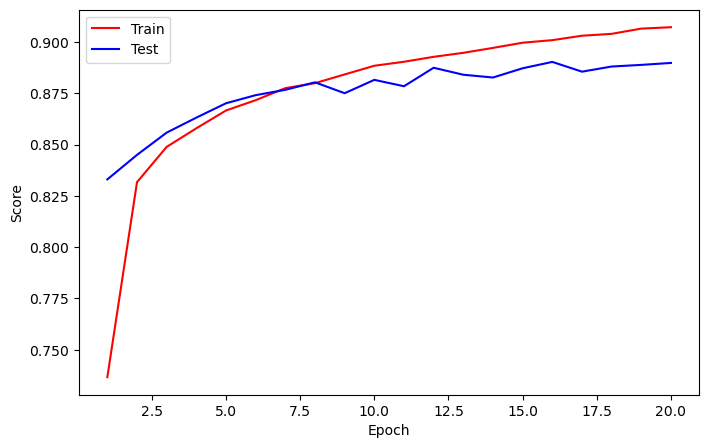

==> EarlyStop patience =  4 | Best test_score: 0.8902


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    21
Train_cost  = 0.2458 | Test_cost  = 0.3062 | Train_score = 0.9081 | Test_score = 0.8921 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    22
Train_cost  = 0.2403 | Test_cost  = 0.3043 | Train_score = 0.9096 | Test_score = 0.8905 |
==> EarlyStop patience =  1 | Best test_score: 0.8921


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    23
Train_cost  = 0.2368 | Test_cost  = 0.3013 | Train_score = 0.9135 | Test_score = 0.8934 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    24
Train_cost  = 0.2324 | Test_cost  = 0.3500 | Train_score = 0.9136 | Test_score = 0.8792 |
==> EarlyStop patience =  1 | Best test_score: 0.8934


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch    25
Train_cost  = 0.2292 | Test_cost  = 0.3232 | Train_score = 0.9136 | Test_score = 0.8878 |
==> EarlyStop patience =  2 | Best test_score: 0.8934


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    26
Train_cost  = 0.2228 | Test_cost  = 0.3194 | Train_score = 0.9164 | Test_score = 0.8899 |
==> EarlyStop patience =  3 | Best test_score: 0.8934


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:09<?, ?it/s]


Epoch    27
Train_cost  = 0.2210 | Test_cost  = 0.3095 | Train_score = 0.9176 | Test_score = 0.8942 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    28
Train_cost  = 0.2175 | Test_cost  = 0.3286 | Train_score = 0.9177 | Test_score = 0.8907 |
==> EarlyStop patience =  1 | Best test_score: 0.8942


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    29
Train_cost  = 0.2154 | Test_cost  = 0.3122 | Train_score = 0.9205 | Test_score = 0.8946 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    30
Train_cost  = 0.2143 | Test_cost  = 0.3018 | Train_score = 0.9205 | Test_score = 0.8952 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    31
Train_cost  = 0.2082 | Test_cost  = 0.3115 | Train_score = 0.9224 | Test_score = 0.8954 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    32
Train_cost  = 0.2039 | Test_cost  = 0.3170 | Train_score = 0.9232 | Test_score = 0.8915 |
==> EarlyStop patience =  1 | Best test_score: 0.8954


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    33
Train_cost  = 0.2034 | Test_cost  = 0.3103 | Train_score = 0.9238 | Test_score = 0.8931 |
==> EarlyStop patience =  2 | Best test_score: 0.8954


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    34
Train_cost  = 0.2027 | Test_cost  = 0.3197 | Train_score = 0.9234 | Test_score = 0.8960 |


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:07<?, ?it/s]


Epoch    35
Train_cost  = 0.1978 | Test_cost  = 0.3163 | Train_score = 0.9265 | Test_score = 0.8927 |
==> EarlyStop patience =  1 | Best test_score: 0.8960


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    36
Train_cost  = 0.1941 | Test_cost  = 0.3256 | Train_score = 0.9264 | Test_score = 0.8924 |
==> EarlyStop patience =  2 | Best test_score: 0.8960


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    37
Train_cost  = 0.1927 | Test_cost  = 0.3208 | Train_score = 0.9286 | Test_score = 0.8907 |
==> EarlyStop patience =  3 | Best test_score: 0.8960


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:08<?, ?it/s]


Epoch    38
Train_cost  = 0.1892 | Test_cost  = 0.3221 | Train_score = 0.9295 | Test_score = 0.8935 |
==> EarlyStop patience =  4 | Best test_score: 0.8960


Train:   0%|          | 0/313 [00:06<?, ?it/s]

Test:   0%|          | 0/157 [00:07<?, ?it/s]


Epoch    39
Train_cost  = 0.1870 | Test_cost  = 0.3424 | Train_score = 0.9296 | Test_score = 0.8889 |
==> EarlyStop patience =  5 | Best test_score: 0.8960
==> Execute Early Stopping at epoch: 39 | Best test_score: 0.8960
==> Best model is saved at model


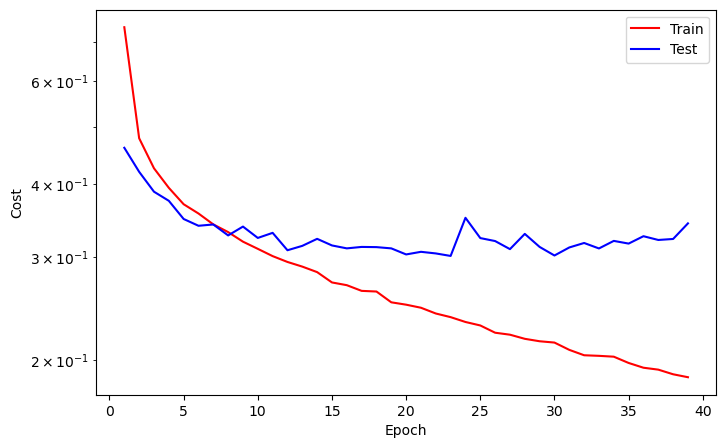

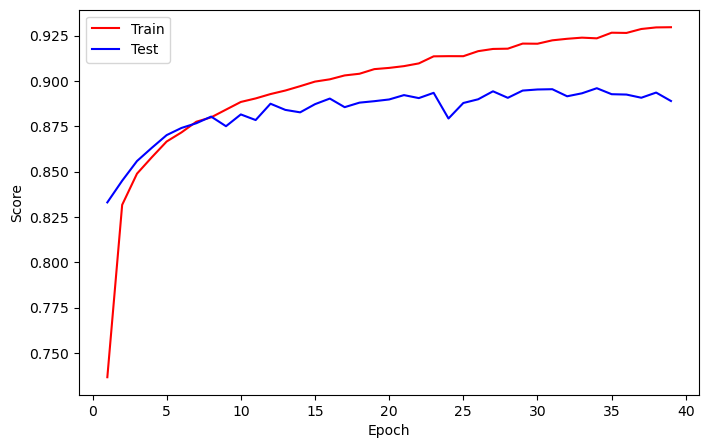

In [17]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    #Logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    #Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    
    # Early Stopping
    if callback.early_stopping(model,monitor='test_score' ):
        callback.plot_cost()
        callback.plot_score()
        break
    
    

# Load best model 

In [ ]:
# weights = torch.load('model/weights_best.pth', map_location='cpu')
# config = torch.load('model/configs.pth', map_location='cpu')

# model = FashionClassifier(config.input_size, config.n1, config.n2,  config.output_size, config.dropout)
# model.load_state_dict(weights)
# model = model.to(device)

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
[label2cat[pred] for pred in preds]